# Explore GIOP on L23

In [1]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from oceancolor.hydrolight import loisel23
from oceancolor.utils import plotting as oc_plotting

from boring.models import anw as boring_anw
from boring.models import bbnw as boring_bbnw
from boring.models import utils as model_utils
from boring.models import functions
from boring import inference as big_inf
from boring import rt as big_rt
from boring import chisq_fit
from boring import plotting as boring_plotting

import anly_utils

In [2]:
%matplotlib ipympl

# Load

## L23

In [3]:
ds = loisel23.load_ds(4,0)

### Unpack

In [4]:
l23_wave = ds.Lambda.data
l23_Rrs = ds.Rrs.data
a = ds.a.data
bb = ds.bb.data
adg = ds.ag.data + ds.ad.data
aph = ds.aph.data
anw = ds.anw.data

## Fits

In [5]:
ks = [3,4,5,9,10]
k_giopm = 9
k_giop = 10
pdict = {}
for k in ks:
    pdict[k] = {}
    # Model names
    if k == 3:
        model_names = ['Exp', 'Cst']
    elif k == 4:
        model_names = ['Exp', 'Pow']
    elif k == 5:
        model_names = ['ExpBricaud', 'Pow']
    elif k == k_giopm:  # GIOP-
        model_names = ['ExpBricaud', 'Lee']
    elif k == k_giop:  # GIOP (with fixed Sdg)
        model_names = ['GIOP', 'Lee']
    else:
        raise ValueError("Bad k")

    chain_file, noises, noise_lbl = anly_utils.get_chain_file(
        model_names, 0.02, False, 'L23', use_LM=True,
        PACE=True)
    # Load up
    d = np.load(chain_file)
    # Parse
    pdict[k]['params'] = d['ans']
    pdict[k]['Chl'] = d['Chl']
    pdict[k]['Y'] = d['Y']
    if k == ks[0]:
        pdict['Rrs'] = d['obs_Rrs']
        pdict['idx'] = d['idx']
        pdict['wave'] = d['wave']
    #import pdb; pdb.set_trace()

In [6]:
pdict[4]['params'].shape

(3320, 4)

## Models

In [7]:
model_names = ['ExpBricaud', 'Lee']
#anw_model = big_anw.init_model(model_names[0], pdict['wave'])
#bbnw_model = big_bbnw.init_model(model_names[1], pdict['wave'])
#models = [anw_model, bbnw_model]
models = model_utils.init(model_names, pdict['wave'])

# Calc a few things

## $a_{\rm ph}(440)$

In [8]:
i440_l23 = np.argmin(np.abs(l23_wave-440.))
i440_giopm = np.argmin(np.abs(pdict['wave']-440.))

In [9]:
l23_a440 = aph[:,i440_l23]
l23_a440.shape

(3320,)

### Bricaud

In [10]:
def calc_aph440(idict:dict):
    aph_fits = []
    for ss in range(aph.shape[0]):
        models[0].set_aph(idict['Chl'][ss])
        #
        iaph = functions.gen_basis(idict['params'][ss,-1:], [models[0].a_ph])
        #import pdb; pdb.set_trace()
        aph_fits.append(iaph.flatten())
    #
    aph_fits = np.array(aph_fits)
    aph_fits.shape
    #
    giop_a440 = aph_fits[:, i440_giopm]
    return giop_a440

In [11]:
giopm_a440 = calc_aph440(pdict[k_giopm])
giop_a440 = calc_aph440(pdict[k_giop])

# Plots

## $a_{\rm ph}$

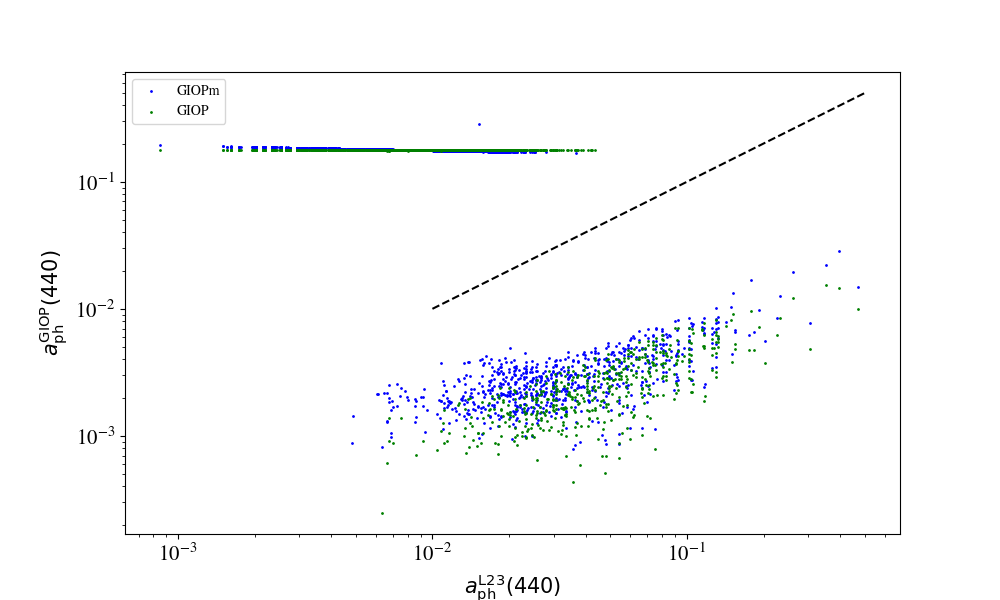

In [12]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
#
ax.scatter(l23_a440, giopm_a440, s=1, color='b', label='GIOPm')
ax.scatter(l23_a440, giop_a440, s=1, color='g', label='GIOP')
#
xmin, xmax = 0.01, 0.5
ax.plot([xmin, xmax], [xmin, xmax], 'k--')
# Log
ax.set_xscale('log')
ax.set_yscale('log')
#
ax.set_xlabel(r'$a_{\rm ph}^{\rm L23} (440)$')
ax.set_ylabel(r'$a_{\rm ph}^{\rm GIOP} (440)$')
#
oc_plotting.set_fontsize(ax, 15)
ax.legend()
#
plt.show()

----

# Check individual fits

In [13]:
high_giop = giop_a440 > 0.1
high_idx = np.where(high_giop)[0]
np.sum(high_giop)

2833

In [14]:
pdict[k_giop]['params'].shape

(3320, 4)

In [16]:
idx = high_idx[0]
idx, 10**pdict[k_giop]['params'][idx,:]

(0, array([1.52373670e+56, 2.75564941e+25, 1.06080004e-03, 1.77481965e-01]))

[<Axes: xlabel='Wavelength (nm)', ylabel='$a_{\\rm nw}(\\lambda) \\; [{\\rm m}^{-1}]$'>,
 <Axes: xlabel='Wavelength (nm)', ylabel='$b_{b,nw}(\\lambda) \\; [{\\rm m}^{-1}]$'>,
 <Axes: xlabel='Wavelength (nm)', ylabel='$R_{rs}(\\lambda) \\; [10^{-4} \\, {\\rm sr}^{-1}$]'>]

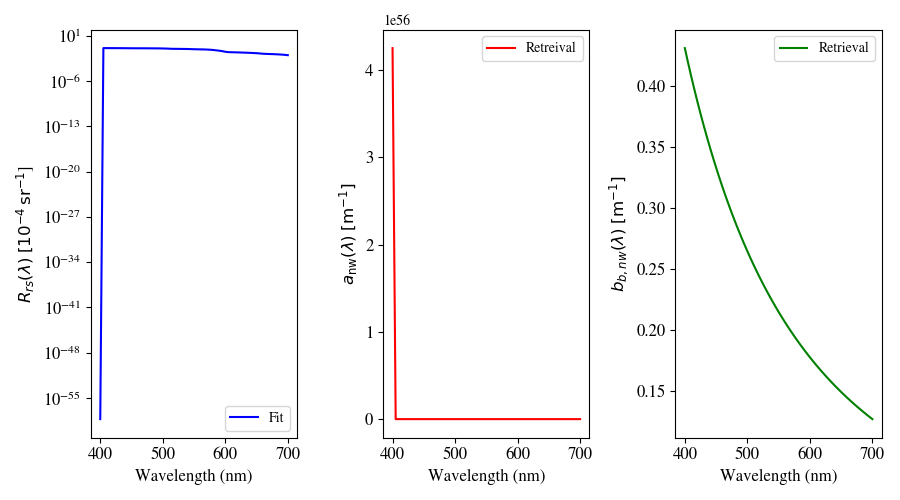

In [40]:
# Set aph
models[0].set_aph(pdict[k_giop]['Chl'][idx])
#
boring_plotting.show_fit(models,     #pdict[k_giop]['params'][idx,:],
    np.atleast_1d(pdict[k_giop]['Chl'][idx]), 
    np.atleast_1d(pdict[k_giop]['Y'][idx]),
                        figsize=(9,5)) 